# 内容
- lightGBMモデル初版
- ターゲットエンコーディング：Holdout TS
- 外部データ3つ(ステージ面積1,ステージ面積2,ブキ)を結合
    - ステージ面積1:
    https://probspace-stg.s3-ap-northeast-1.amazonaws.com/uploads/user/c10947bba5cde4ad3dd4a0d42a0ec35b/files/2020-09-06-0320/stagedata.csv
    - ステージ面積2:https://stat.ink/api-info/stage2
    - ブキ:https://stat.ink/api-info/weapon2

In [187]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [188]:
# データの読込
train = pd.read_csv("../data/train_data.csv")
test = pd.read_csv('../data/test_data.csv')

# データの確認

In [189]:
def inspection_datas(df):
    print('######################################')
    print('①サイズ（行数、列数）の確認')
    print(df.shape)
    print('######################################')
    print('②最初の５行の表示')
    display(df.head())
    print('######################################')
    print('③各行のデータ型の確認（オブジェクト型の有無）')
    display(df.info())
    display(df.select_dtypes(include=object).columns)
    print('######################################')
    print('④各種統計値の確認（③で、Objectのものは統計されない）')
    display(df.describe())
    print('######################################')
    print('➄欠損値がある列の確認')
    null_df =df.isnull().sum()[df.columns[df.isnull().sum()!=0]]
    display(null_df)
    display(null_df.shape)
    print('######################################')
    print('⑥相関係数のヒートマップ')
    sns.heatmap(df.corr())

######################################
①サイズ（行数、列数）の確認
(66125, 32)
######################################
②最初の５行の表示


,id,period,game-ver,lobby-mode,lobby,mode,stage,A1-weapon,A1-rank,A1-level,...,B2-weapon,B2-rank,B2-level,B3-weapon,B3-rank,B3-level,B4-weapon,B4-rank,B4-level,y
0,1,2019-10-15T20:00:00+00:00,5.0.1,regular,standard,nawabari,sumeshi,sshooter_becchu,NaN,139,...,hokusai_becchu,NaN,26.0,herocharger_replica,NaN,68.0,sharp_neo,NaN,31.0,1
1,2,2019-12-14T04:00:00+00:00,5.0.1,regular,standard,nawabari,arowana,parashelter_sorella,NaN,198,...,squiclean_b,NaN,118.0,campingshelter,NaN,168.0,sputtery_clear,NaN,151.0,0
2,3,2019-12-25T14:00:00+00:00,5.0.1,gachi,standard,hoko,ama,nzap89,a-,114,...,nzap85,a+,163.0,prime_becchu,a-,160.0,dualsweeper_custom,a,126.0,0
3,4,2019-11-11T14:00:00+00:00,5.0.1,regular,standard,nawabari,engawa,bamboo14mk1,NaN,336,...,liter4k,NaN,189.0,promodeler_mg,NaN,194.0,hotblaster_custom,NaN,391.0,0
4,5,2019-12-14T06:00:00+00:00,5.0.1,gachi,standard,hoko,chozame,bold_7,x,299,...,sputtery_hue,x,45.0,bucketslosher_soda,x,246.0,wakaba,x,160.0,1


######################################
③各行のデータ型の確認（オブジェクト型の有無）
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66125 entries, 0 to 66124
Data columns (total 32 columns):
id            66125 non-null int64
period        66125 non-null object
game-ver      66125 non-null object
lobby-mode    66125 non-null object
lobby         66125 non-null object
mode          66125 non-null object
stage         66125 non-null object
A1-weapon     66125 non-null object
A1-rank       51681 non-null object
A1-level      66125 non-null int64
A2-weapon     66125 non-null object
A2-rank       51681 non-null object
A2-level      66125 non-null float64
A3-weapon     66125 non-null object
A3-rank       51681 non-null object
A3-level      66125 non-null float64
A4-weapon     66074 non-null object
A4-rank       51638 non-null object
A4-level      66074 non-null float64
B1-weapon     66125 non-null object
B1-rank       51681 non-null object
B1-level      66125 non-null int64
B2-weapon     66125 non-null object


None

Index(['period', 'game-ver', 'lobby-mode', 'lobby', 'mode', 'stage',
       'A1-weapon', 'A1-rank', 'A2-weapon', 'A2-rank', 'A3-weapon', 'A3-rank',
       'A4-weapon', 'A4-rank', 'B1-weapon', 'B1-rank', 'B2-weapon', 'B2-rank',
       'B3-weapon', 'B3-rank', 'B4-weapon', 'B4-rank'],
      dtype='object')

######################################
④各種統計値の確認（③で、Objectのものは統計されない）


,id,A1-level,A2-level,A3-level,A4-level,B1-level,B2-level,B3-level,B4-level,y
count,66125.000000,66125.000000,66125.000000,66125.000000,66074.000000,66125.000000,66125.000000,66124.000000,66058.000000,66125.000000
mean,33063.000000,208.838926,155.351698,153.175229,156.001619,156.378722,152.764749,153.105393,157.869736,0.524703
std,19088.787612,118.986528,96.183950,95.470733,95.524571,97.109501,95.373534,94.891705,95.777647,0.499393
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,16532.000000,120.000000,82.000000,80.000000,84.000000,83.000000,80.000000,81.000000,86.000000,0.000000
50%,33063.000000,188.000000,139.000000,137.000000,140.000000,139.000000,136.000000,137.000000,142.000000,1.000000
75%,49594.000000,277.000000,208.000000,205.000000,208.000000,210.000000,205.000000,205.000000,212.000000,1.000000
max,66125.000000,585.000000,913.000000,920.000000,931.000000,920.000000,913.000000,933.000000,936.000000,1.000000


######################################
➄欠損値がある列の確認


A1-rank      14444
A2-rank      14444
A3-rank      14444
A4-weapon       51
A4-rank      14487
A4-level        51
B1-rank      14444
B2-rank      14444
B3-weapon        1
B3-rank      14444
B3-level         1
B4-weapon       67
B4-rank      14501
B4-level        67
dtype: int64

(14,)

######################################
⑥相関係数のヒートマップ


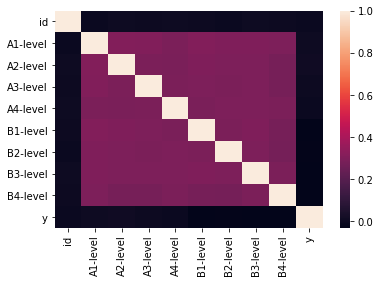

In [190]:
inspection_datas(train)

# 外部データの結合

In [191]:
# 外部データの読込
# stage,stage2は若干面積が異なる、バージョンによる違いや計算方法による誤差
stage = pd.read_csv('../gaibu_data/stagedata.csv')
stage2 = pd.read_json('../gaibu_data/stage.json')
weapon = pd.read_csv('../gaibu_data/statink-weapon2.csv')

In [192]:
stage.head(3)

,stage,size
0,sumeshi,2855.0
1,arowana,2391.0
2,ama,2426.0


In [193]:
stage2.head(3)

,area,key,name,release_at,short_name,splatnet
0,2450.0,battera,"{'de_DE': 'Korallenviertel', 'en_GB': 'The Ree...","{'time': 1490382000, 'iso8601': '2017-03-24T19...","{'de_DE': 'Korallenviertel', 'en_GB': 'Reef', ...",0
1,1957.0,fujitsubo,"{'de_DE': 'Molluskelbude', 'en_GB': 'Musselfor...","{'time': 1490382000, 'iso8601': '2017-03-24T19...","{'de_DE': 'Molluskelbude', 'en_GB': 'Fitness',...",1
2,2140.0,gangaze,"{'de_DE': 'Seeigel-Rockbühne', 'en_GB': 'Starf...","{'time': 1500105600, 'iso8601': '2017-07-15T08...","{'de_DE': 'Seeigel-Rockbühne', 'en_GB': 'Mains...",2


In [194]:
weapon.head(3)

,category1,category2,key,subweapon,special,mainweapon,reskin,splatnet,[de-DE],[en-GB],...,[es-ES],[es-MX],[fr-CA],[fr-FR],[it-IT],[ja-JP],[nl-NL],[ru-RU],[zh-CN],[zh-TW]
0,shooter,shooter,52gal,pointsensor,sphere,52gal,52gal,50,.52 Gallon,.52 Gal,...,Salpicadora 2000,Salpicadora 2000,Calibre 2000,Calibre 2000,Calibro 2000,.52ガロン,.52 Kaliter,Струевик .52,点52口径重枪,點52口徑重槍
1,shooter,shooter,52gal_deco,curlingbomb,presser,52gal,52gal_deco,51,.52 Gallon Deko,.52 Gal Deco,...,Salpicadora 2000 DX,Salpicadora 2000 chic,Calibre 2000 chic,Calibre 2000 chic,Calibro 2000 DX,.52ガロンデコ,.52 Kaliter Deco,Струевик .52 «Деко»,点52口径重枪 Deco,點52口徑重槍 Deco
2,shooter,shooter,96gal,sprinkler,armor,96gal,96gal,80,.96 Gallon,.96 Gal,...,Salpicadora 3000,Salpicadora 3000,Calibre 3000,Calibre 3000,Calibro 3000,.96ガロン,.96 Kaliter,Струевик .96,点96口径重枪,點96口徑重槍


## stageを結合

In [195]:
# 表記揺れの確認
print(np.sort(train['stage'].unique()))
print(np.sort(test['stage'].unique()))
print(np.sort(stage['stage'].unique()))

['ajifry' 'ama' 'anchovy' 'arowana' 'battera' 'bbass' 'chozame' 'devon'
 'engawa' 'fujitsubo' 'gangaze' 'hakofugu' 'hokke' 'kombu' 'manta'
 'mongara' 'mozuku' 'mutsugoro' 'otoro' 'shottsuru' 'sumeshi' 'tachiuo'
 'zatou']
['ajifry' 'ama' 'anchovy' 'arowana' 'battera' 'bbass' 'chozame' 'devon'
 'engawa' 'fujitsubo' 'gangaze' 'hakofugu' 'hokke' 'kombu' 'manta'
 'mongara' 'mozuku' 'mutsugoro' 'otoro' 'shottsuru' 'sumeshi' 'tachiuo'
 'zatou']
['ajifry' 'ama' 'anchovy' 'arowana' 'battera' 'bbass' 'chozame' 'devon'
 'engawa' 'fujitsubo' 'gangaze' 'hakofugu' 'hokke' 'kombu' 'manta'
 'mongara' 'mozuku' 'mutsugoro' 'otoro' 'shottsuru' 'sumeshi' 'tachiuo'
 'zatou']


In [196]:
# 結合のため列名変更
stage_r = stage.rename(columns = {'size':'stage_size1'})
# 結合
train_s = pd.merge(train, stage_r, on = 'stage', how = 'left')
test_s = pd.merge(test, stage_r, on = 'stage', how = 'left')

# null確認
print(train_s[['stage_size1']].isnull().sum())
print(test_s[['stage_size1']].isnull().sum())

stage_size1    0
dtype: int64
stage_size1    0
dtype: int64


## stage2を結合

In [197]:
# 表記揺れの確認
print(np.sort(train['stage'].unique()))
print(np.sort(test['stage'].unique()))
# 「mystery~」はイベント時に解放されるステージ、今回のtrain,testデータには無し
print(np.sort(stage2['key'].unique()))

['ajifry' 'ama' 'anchovy' 'arowana' 'battera' 'bbass' 'chozame' 'devon'
 'engawa' 'fujitsubo' 'gangaze' 'hakofugu' 'hokke' 'kombu' 'manta'
 'mongara' 'mozuku' 'mutsugoro' 'otoro' 'shottsuru' 'sumeshi' 'tachiuo'
 'zatou']
['ajifry' 'ama' 'anchovy' 'arowana' 'battera' 'bbass' 'chozame' 'devon'
 'engawa' 'fujitsubo' 'gangaze' 'hakofugu' 'hokke' 'kombu' 'manta'
 'mongara' 'mozuku' 'mutsugoro' 'otoro' 'shottsuru' 'sumeshi' 'tachiuo'
 'zatou']
['ajifry' 'ama' 'anchovy' 'arowana' 'battera' 'bbass' 'chozame' 'devon'
 'engawa' 'fujitsubo' 'gangaze' 'hakofugu' 'hokke' 'kombu' 'manta'
 'mongara' 'mozuku' 'mutsugoro' 'mystery' 'mystery_01' 'mystery_02'
 'mystery_03' 'mystery_04' 'mystery_05' 'mystery_06' 'mystery_07'
 'mystery_08' 'mystery_09' 'mystery_10' 'mystery_11' 'mystery_12'
 'mystery_13' 'mystery_14' 'mystery_15' 'mystery_16' 'mystery_17'
 'mystery_18' 'mystery_19' 'mystery_20' 'mystery_21' 'mystery_22'
 'mystery_23' 'mystery_24' 'otoro' 'shottsuru' 'sumeshi' 'tachiuo' 'zatou']


In [198]:
stage2_r.columns

Index(['stage_size2', 'stage', 'name', 'release_at', 'short_name', 'splatnet'], dtype='object')

In [199]:
# 結合のため列名変更
stage2_r = stage2.rename(columns = {'key':'stage', 'area':'stage_size2'})

In [200]:
# 必要カラム
st2_col = ['stage_size2', # ステージの面積
           'stage', # ステージ名
#            'name', # 外国語ステージ名
#            'release_at', #リリース日時
#            'short_name', # 省略名
#            'splatnet' # ID?
          ]
stage2_rc = stage2_r[st2_col]

In [201]:
# 結合
train_ss = pd.merge(train_s, stage2_rc, on = 'stage', how = 'left')
test_ss = pd.merge(test_s, stage2_rc, on = 'stage', how = 'left')

# null確認
print(train_ss[['stage_size2']].isnull().sum())
print(test_ss[['stage_size2']].isnull().sum())

stage_size2    0
dtype: int64
stage_size2    0
dtype: int64


## weaponを結合

In [202]:
# trainのブキ
train_weapon = sorted(list(set(train['A1-weapon'])&set(train['A2-weapon'])&set(train['A3-weapon'])&set(train['A4-weapon'])\
&set(train['B1-weapon'])&set(train['B2-weapon'])&set(train['B3-weapon'])&set(train['B4-weapon'])))
print('{}種類'.format(len(train_weapon)))
print(train_weapon)

139種類
['52gal', '52gal_becchu', '52gal_deco', '96gal', '96gal_deco', 'bamboo14mk1', 'bamboo14mk2', 'bamboo14mk3', 'barrelspinner', 'barrelspinner_deco', 'barrelspinner_remix', 'bold', 'bold_7', 'bold_neo', 'bottlegeyser', 'bottlegeyser_foil', 'bucketslosher', 'bucketslosher_deco', 'bucketslosher_soda', 'campingshelter', 'campingshelter_camo', 'campingshelter_sorella', 'carbon', 'carbon_deco', 'clashblaster', 'clashblaster_neo', 'dualsweeper', 'dualsweeper_custom', 'dynamo', 'dynamo_becchu', 'dynamo_tesla', 'explosher', 'explosher_custom', 'furo', 'furo_deco', 'h3reelgun', 'h3reelgun_cherry', 'h3reelgun_d', 'heroblaster_replica', 'herobrush_replica', 'herocharger_replica', 'heromaneuver_replica', 'heroroller_replica', 'heroshelter_replica', 'heroshooter_replica', 'heroslosher_replica', 'herospinner_replica', 'hissen', 'hissen_hue', 'hokusai', 'hokusai_becchu', 'hokusai_hue', 'hotblaster', 'hotblaster_custom', 'hydra', 'hydra_custom', 'jetsweeper', 'jetsweeper_custom', 'kelvin525', 'kelv

In [203]:
# testのブキ
test_weapon = sorted(list(set(test['A1-weapon'])&set(test['A2-weapon'])&set(test['A3-weapon'])&set(test['A4-weapon'])\
&set(test['B1-weapon'])&set(test['B2-weapon'])&set(test['B3-weapon'])&set(test['B4-weapon'])))
print('{}種類'.format(len(test_weapon)))
print(test_weapon)

139種類
['52gal', '52gal_becchu', '52gal_deco', '96gal', '96gal_deco', 'bamboo14mk1', 'bamboo14mk2', 'bamboo14mk3', 'barrelspinner', 'barrelspinner_deco', 'barrelspinner_remix', 'bold', 'bold_7', 'bold_neo', 'bottlegeyser', 'bottlegeyser_foil', 'bucketslosher', 'bucketslosher_deco', 'bucketslosher_soda', 'campingshelter', 'campingshelter_camo', 'campingshelter_sorella', 'carbon', 'carbon_deco', 'clashblaster', 'clashblaster_neo', 'dualsweeper', 'dualsweeper_custom', 'dynamo', 'dynamo_becchu', 'dynamo_tesla', 'explosher', 'explosher_custom', 'furo', 'furo_deco', 'h3reelgun', 'h3reelgun_cherry', 'h3reelgun_d', 'heroblaster_replica', 'herobrush_replica', 'herocharger_replica', 'heromaneuver_replica', 'heroroller_replica', 'heroshelter_replica', 'heroshooter_replica', 'heroslosher_replica', 'herospinner_replica', 'hissen', 'hissen_hue', 'hokusai', 'hokusai_becchu', 'hokusai_hue', 'hotblaster', 'hotblaster_custom', 'hydra', 'hydra_custom', 'jetsweeper', 'jetsweeper_custom', 'kelvin525', 'kelv

In [204]:
# 外部データのブキ
gaibu_weapon = train_weapon = np.sort(weapon['key'].unique())
print('{}種類'.format(len(gaibu_weapon)))
print(gaibu_weapon)

139種類
['52gal' '52gal_becchu' '52gal_deco' '96gal' '96gal_deco' 'bamboo14mk1'
 'bamboo14mk2' 'bamboo14mk3' 'barrelspinner' 'barrelspinner_deco'
 'barrelspinner_remix' 'bold' 'bold_7' 'bold_neo' 'bottlegeyser'
 'bottlegeyser_foil' 'bucketslosher' 'bucketslosher_deco'
 'bucketslosher_soda' 'campingshelter' 'campingshelter_camo'
 'campingshelter_sorella' 'carbon' 'carbon_deco' 'clashblaster'
 'clashblaster_neo' 'dualsweeper' 'dualsweeper_custom' 'dynamo'
 'dynamo_becchu' 'dynamo_tesla' 'explosher' 'explosher_custom' 'furo'
 'furo_deco' 'h3reelgun' 'h3reelgun_cherry' 'h3reelgun_d'
 'heroblaster_replica' 'herobrush_replica' 'herocharger_replica'
 'heromaneuver_replica' 'heroroller_replica' 'heroshelter_replica'
 'heroshooter_replica' 'heroslosher_replica' 'herospinner_replica'
 'hissen' 'hissen_hue' 'hokusai' 'hokusai_becchu' 'hokusai_hue'
 'hotblaster' 'hotblaster_custom' 'hydra' 'hydra_custom' 'jetsweeper'
 'jetsweeper_custom' 'kelvin525' 'kelvin525_becchu' 'kelvin525_deco'
 'kugelschreib

In [205]:
# 表記に差分ないか比較→無し
print(set(train_weapon)-set(gaibu_weapon))
print(set(gaibu_weapon)-set(train_weapon))
print(set(test_weapon)-set(gaibu_weapon))
print(set(gaibu_weapon)-set(test_weapon))

set()
set()
set()
set()


In [206]:
# 必要カラム
# 参照：https://stat.ink/api-info/weapon2
weapon_col = ['category1', # ブキ区分
              'category2', # ブキ区分
              'key', # ブキ名
              'subweapon', # サブウェポン
              'special', # スペシャルウェポン
              'mainweapon', # メインブキ
              'reskin', # 同一性能のブキ
#              'splatnet', # アプリのユーザID
# 以下外国語ブキ名
#               '[de-DE]', '[en-GB]', '[en-US]', '[es-ES]','[es-MX]', '[fr-CA]', 
#               '[fr-FR]', '[it-IT]', '[ja-JP]', '[nl-NL]','[ru-RU]', '[zh-CN]', '[zh-TW]'   
]

In [207]:
# 必要カラム抽出＆結合キー名変更
weapon_c = weapon[weapon_col].rename(columns = {'key': 'weapon'})
weapon_c.head(3)

,category1,category2,weapon,subweapon,special,mainweapon,reskin
0,shooter,shooter,52gal,pointsensor,sphere,52gal,52gal
1,shooter,shooter,52gal_deco,curlingbomb,presser,52gal,52gal_deco
2,shooter,shooter,96gal,sprinkler,armor,96gal,96gal


In [208]:
# 各A1~B4-weapon列に対して結合
weapon_cc = weapon_c.copy()
train_ssw = train_ss.copy()
test_ssw = test_ss.copy()
import itertools

for a,num in itertools.product(['A','B'],[1,2,3,4]):
    col_list = []
    # ブキのカラム名の先頭にA1~B4追加
    for col in weapon_c.columns:
        tmp_col = a+str(num) + '-' + col
        col_list.append(tmp_col)
    weapon_cc.columns = col_list
    #train,testに結合
    train_ssw = pd.merge(train_ssw, weapon_cc, on = a+str(num) + '-weapon', how = 'left')
    test_ssw = pd.merge(test_ssw, weapon_cc, on = a+str(num) + '-weapon', how = 'left')
    # 結合後nullチェック
    print(train_ssw[col_list].isnull().sum())
    print(test_ssw[col_list].isnull().sum())

A1-category1     0
A1-category2     0
A1-weapon        0
A1-subweapon     0
A1-special       0
A1-mainweapon    0
A1-reskin        0
dtype: int64
A1-category1     0
A1-category2     0
A1-weapon        0
A1-subweapon     0
A1-special       0
A1-mainweapon    0
A1-reskin        0
dtype: int64
A2-category1     0
A2-category2     0
A2-weapon        0
A2-subweapon     0
A2-special       0
A2-mainweapon    0
A2-reskin        0
dtype: int64
A2-category1     0
A2-category2     0
A2-weapon        0
A2-subweapon     0
A2-special       0
A2-mainweapon    0
A2-reskin        0
dtype: int64
A3-category1     0
A3-category2     0
A3-weapon        0
A3-subweapon     0
A3-special       0
A3-mainweapon    0
A3-reskin        0
dtype: int64
A3-category1     0
A3-category2     0
A3-weapon        0
A3-subweapon     0
A3-special       0
A3-mainweapon    0
A3-reskin        0
dtype: int64
A4-category1     51
A4-category2     51
A4-weapon        51
A4-subweapon     51
A4-special       51
A4-mainweapon    51
A4-r

In [209]:
# 元データにweapon情報がないもののみ(回線落ち)がnullなのでok

In [210]:
train_input = train_ssw.copy()
test_input = test_ssw.copy()

# 前処理

In [211]:
# 欠損値埋める
def fill_all_null(df, num):
    for col_name in df.columns[df.isnull().sum()!=0]:
        df[col_name] = df[col_name].fillna(num)

In [212]:
# 訓練データ、テストデータの欠損値を-1で補完
fill_all_null(train_input, -1)
fill_all_null(test_input, -1)

In [213]:
# ターゲットエンコーディングの関数定義
## Holdout TSを用いる 変更の余地あり
def change_to_target2(train_df,test_df,input_column_name,output_column_name):
    from sklearn.model_selection import KFold
    
    # nan埋め処理
    ## 上でやってるのでいらない
    # train_df[input_column_name] = train_df[input_column_name].fillna('-1')
    # test_df[input_column_name] = test_df[input_column_name].fillna('-1')

    kf = KFold(n_splits=5, shuffle=True, random_state=71)
    #=========================================================#
    c=input_column_name
    # 学習データ全体で各カテゴリにおけるyの平均を計算
    data_tmp = pd.DataFrame({c: train_df[c],'target':train_df['y']})
    target_mean = data_tmp.groupby(c)['target'].mean()
    #テストデータのカテゴリを置換★
    test_df[output_column_name] = test_df[c].map(target_mean)
    
    # 変換後の値を格納する配列を準備
    tmp = np.repeat(np.nan, train_df.shape[0])

    for i, (train_index, test_index) in enumerate(kf.split(train_df)): # NFOLDS回まわる
        #学習データについて、各カテゴリにおける目的変数の平均を計算
        target_mean = data_tmp.iloc[train_index].groupby(c)['target'].mean()
        #バリデーションデータについて、変換後の値を一時配列に格納
        tmp[test_index] = train_df[c].iloc[test_index].map(target_mean) 

    #変換後のデータで元の変数を置換
    train_df[output_column_name] = tmp
#========================================================#   


In [214]:
# オブジェクトの列のリストを作成
object_col_list = train_input.select_dtypes(include=object).columns
# オブジェクトの列は全てターゲットエンコーディング実施
for col in object_col_list:
    change_to_target2(train_input,test_input,col,"enc_"+col)
#　変換前の列を削除
train_input = train_input.drop(object_col_list,axis=1)
test_input = test_input.drop(object_col_list,axis=1)
#　'id'の列を削除
train_input = train_input.drop('id',axis=1)
test_input = test_input.drop('id',axis=1)

In [215]:
#　訓練データ欠損確認
train_input.isnull().sum().sum()

18

In [216]:
#　テストデータ欠損確認
test_input.isnull().sum().sum()

2

In [217]:
# 欠損値はターゲットエンコーディング時に学習データが少なくなって平均値が計算できなくなってしまうため発生。0埋め。
fill_all_null(train_input, 0)
fill_all_null(test_input, 0)

# データの確認

In [218]:
# 訓練データとテストデータの列を確認
print(train_input.columns)
print(test_input.columns)

Index(['A1-level', 'A2-level', 'A3-level', 'A4-level', 'B1-level', 'B2-level',
       'B3-level', 'B4-level', 'y', 'stage_size1', 'stage_size2', 'enc_period',
       'enc_game-ver', 'enc_lobby-mode', 'enc_lobby', 'enc_mode', 'enc_stage',
       'enc_A1-weapon', 'enc_A1-rank', 'enc_A2-weapon', 'enc_A2-rank',
       'enc_A3-weapon', 'enc_A3-rank', 'enc_A4-weapon', 'enc_A4-rank',
       'enc_B1-weapon', 'enc_B1-rank', 'enc_B2-weapon', 'enc_B2-rank',
       'enc_B3-weapon', 'enc_B3-rank', 'enc_B4-weapon', 'enc_B4-rank',
       'enc_A1-category1', 'enc_A1-category2', 'enc_A1-subweapon',
       'enc_A1-special', 'enc_A1-mainweapon', 'enc_A1-reskin',
       'enc_A2-category1', 'enc_A2-category2', 'enc_A2-subweapon',
       'enc_A2-special', 'enc_A2-mainweapon', 'enc_A2-reskin',
       'enc_A3-category1', 'enc_A3-category2', 'enc_A3-subweapon',
       'enc_A3-special', 'enc_A3-mainweapon', 'enc_A3-reskin',
       'enc_A4-category1', 'enc_A4-category2', 'enc_A4-subweapon',
       'enc_A4-specia

# 学習の準備

In [219]:
# 訓練データを説明変数と目的変数に分割
target = train_input['y']
train_x = train_input.drop('y',axis=1)
# LGBMのパラメータを設定
params = {
    # 二値分類問題
    'objective': 'binary',
    # 損失関数は二値のlogloss
    #'metric': 'auc',
    'metric': 'binary_logloss',
    # 最大イテレーション回数指定
    'num_iterations' : 1000,
    # early_stopping 回数指定
    'early_stopping_rounds' : 100,
}

# 学習・予測の実行

In [220]:
# k-分割交差検証を使って学習＆予測（K=10）
FOLD_NUM = 10
kf = KFold(n_splits=FOLD_NUM,
              random_state=42)
#lgbmのラウンド数を定義
num_round = 10000

In [221]:
#検証時のスコアを初期化
scores = []

#テストデータの予測値を初期化
pred_cv = np.zeros(len(test.index))


for i, (tdx, vdx) in enumerate(kf.split(train_x, target)):
    print(f'Fold : {i}')
    # 訓練用データと検証用データに分割
    X_train, X_valid, y_train, y_valid = train_x.iloc[tdx], train_x.iloc[vdx], target.values[tdx], target.values[vdx]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid)
    
    # 学習の実行
    model = lgb.train(params, lgb_train, num_boost_round=num_round,
                      valid_names=["train", "valid"], valid_sets=[lgb_train, lgb_valid],
                      verbose_eval=100)

    # 検証データに対する予測値を求めて、勝敗（０　or　１）に変換
    va_pred = np.round(model.predict(X_valid,num_iteration=model.best_iteration))
    
    # accuracyスコアを計算
    score_ = accuracy_score(y_valid, va_pred)
    
    # フォールド毎の検証時のスコアを格納
    scores.append(score_)
    
    #テストデータに対する予測値を求める
    submission = model.predict(test_input,num_iteration=model.best_iteration)
    
    #テストデータに対する予測値をフォールド数で割って蓄積
    #(フォールド毎の予測値の平均値を求めることと同じ)
    pred_cv += submission/FOLD_NUM

# 最終的なテストデータに対する予測値を勝敗（０　or　１）に変換
pred_cv_int = np.round(pred_cv)

# 最終的なaccuracyスコアを平均値で出力
print('')
print('################################')
print('CV_score:'+ str(np.mean(scores)))

Fold : 0
Training until validation scores don't improve for 100 rounds.
[100]	train's binary_logloss: 0.634065	valid's binary_logloss: 0.684154
Early stopping, best iteration is:
[72]	train's binary_logloss: 0.646465	valid's binary_logloss: 0.683221
Fold : 1
Training until validation scores don't improve for 100 rounds.
[100]	train's binary_logloss: 0.633946	valid's binary_logloss: 0.680458
Early stopping, best iteration is:
[91]	train's binary_logloss: 0.638003	valid's binary_logloss: 0.680022
Fold : 2
Training until validation scores don't improve for 100 rounds.
[100]	train's binary_logloss: 0.63433	valid's binary_logloss: 0.684864
Early stopping, best iteration is:
[82]	train's binary_logloss: 0.641942	valid's binary_logloss: 0.68428
Fold : 3
Training until validation scores don't improve for 100 rounds.
[100]	train's binary_logloss: 0.634298	valid's binary_logloss: 0.685253
Early stopping, best iteration is:
[57]	train's binary_logloss: 0.653094	valid's binary_logloss: 0.685024
Fo

In [223]:
# 提出用ファイルを作成する
pd.DataFrame({"id": range(len(pred_cv_int)), "y": pred_cv_int.astype(np.int64) }).to_csv("../submit/submission_v0.2.csv", index=False)